# Load Dependencies 📦


In [1]:
!pip install patchify
from patchify import patchify
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from tqdm import tqdm
import torchvision.models as models
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.math import log , reduce_mean
from tensorflow.keras.utils import to_categorical
import torch
from tqdm import tqdm


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Importing & Patching Data 💾


In [2]:
root_directory = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/"
patch_size = 256
scaler = MinMaxScaler()

In [3]:
image_dataset = []
for path,subdirs,files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):                
                image = cv2.imread(path+"/"+image_name,1)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):  
                        single_patch_img = patches_img[i,j,0,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

In [4]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                
                mask = cv2.imread(path+'/'+mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):  
                        single_patch_mask = patches_mask[i,j,0,:,:]
                        mask_dataset.append(single_patch_mask)

In [5]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

# Data Visualization 🖼️

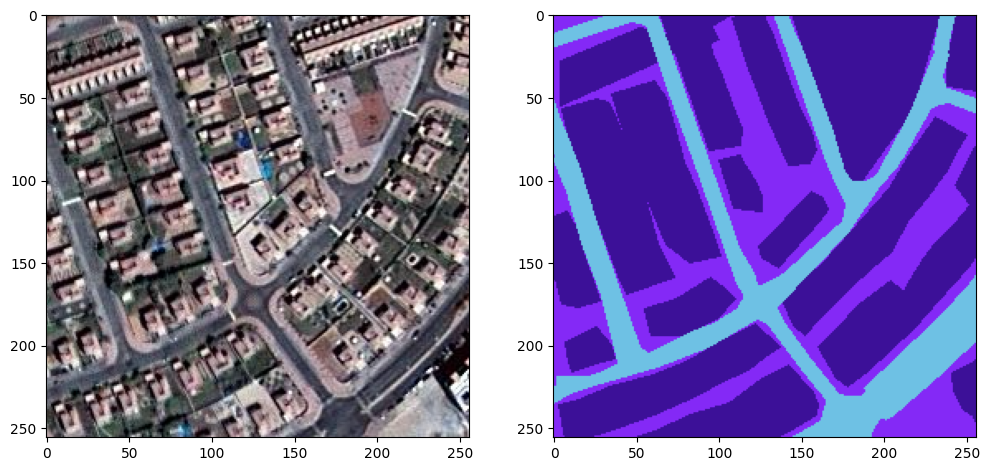

In [6]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

# Masks Encoding 

In [7]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [8]:
label = single_patch_mask

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label == Unlabeled, axis = -1)] = 0
    label_seg [np.all(label == Land, axis = -1)] = 1
    label_seg [np.all(label == Road, axis = -1)] = 2  
    label_seg [np.all(label == Vegetation, axis = -1)] = 3   
    label_seg [np.all(label == Water, axis = -1)] = 4
    label_seg [np.all(label == Building, axis = -1)] = 5
    
    label_seg = label_seg[:,:,0]
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

    
labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


In [9]:
labels = np.array(labels)
labels_cat = to_categorical(labels)
labels_cat.shape

(1305, 256, 256, 6)

# DataLoaders & Augmentation🔧


In [10]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


In [11]:
def get_train_augs():
    albumentations_transform = [
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ToTensorV2()
    ]
    return A.Compose(albumentations_transform)


def get_valid_augs():
    return A.Compose([
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ToTensorV2()
    ])

In [12]:
class SegmentationDataset(Dataset):
    def __init__(self, imagesPath, masksPath, augmentations):
        self.imagesPath = imagesPath
        self.masksPath = masksPath
        self.augmentations = augmentations

    def __len__(self):
        return len(self.imagesPath)

    def __getitem__(self, idx):
        image = self.imagesPath[idx]
        mask = self.masksPath[idx]

        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        #image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))            
            
        return image, mask

In [13]:
trainDataset = SegmentationDataset(X_train,y_train , get_train_augs())
testDataset = SegmentationDataset(X_test, y_test, get_valid_augs())

In [14]:
trainDataLoader = DataLoader(trainDataset , batch_size =16)
testDataLoader = DataLoader(testDataset , batch_size =16)

# Encoded Masks Visualization

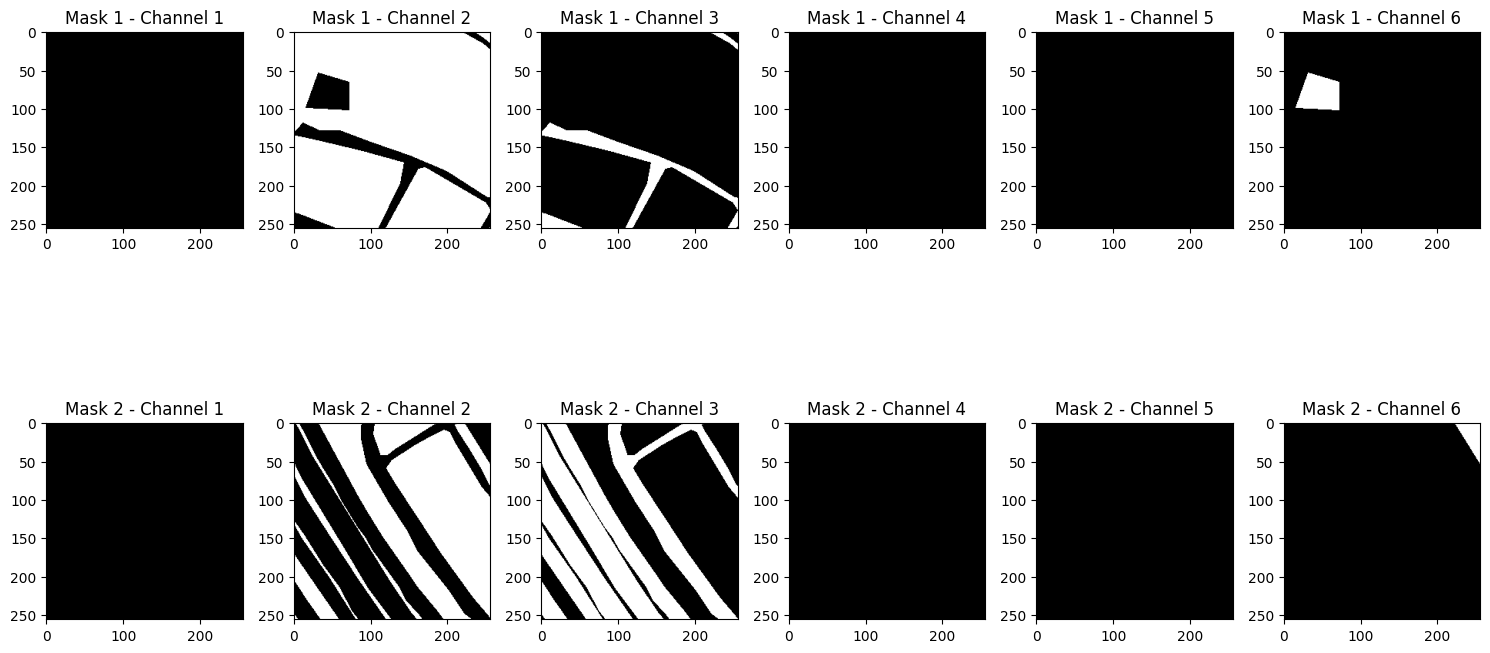

In [15]:
num_masks ,width, height ,num_channels= labels_cat.shape

mask1_index = 40
mask2_index = 10

mask1 = labels_cat[mask1_index]
mask2 = labels_cat[mask2_index]

fig, axes = plt.subplots(nrows=2, ncols=num_channels, figsize=(15, 9))

for channel in range(num_channels):
    axes[0, channel].imshow(mask1[:,:,channel], cmap='gray')
    axes[0, channel].set_title(f'Mask 1 - Channel {channel + 1}')


for channel in range(num_channels):
    axes[1, channel].imshow(mask2[:,:,channel], cmap='gray')
    axes[1, channel].set_title(f'Mask 2 - Channel {channel + 1}')

plt.tight_layout()
plt.show()

# Dise Loss

In [16]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.0

        iflat = input.reshape(-1)
        tflat = target.reshape(-1)
        intersection = (iflat * tflat).sum()

        dice_loss = 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

        return dice_loss

    def calculate_average_dice_loss(self, inputs, targets):
        num_channels = inputs.size(1)

        # Calculate Dice loss for each channel
        dice_losses = []
        for channel in range(num_channels):
            input_channel = inputs[:, channel, ...].unsqueeze(1)
            target_channel = targets[:, channel, ...].unsqueeze(1)
            dice_loss_channel = self.forward(input_channel, target_channel)
            dice_losses.append(dice_loss_channel)

        # Calculate average Dice loss
        average_dice_loss = torch.mean(torch.stack(dice_losses))

        return average_dice_loss
    
dice_loss=DiceLoss()

# Model Architecture 👷


### SegNet using depthwise convolution with Skip-Connections

In [17]:
class DepthwiseSeparableConv(nn.Module):

    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(chin, chin, kernel_size=kernel_size, padding=kernel_size//2, groups=chin, bias=False),
            nn.Conv2d(chin, chout, kernel_size=1, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.seq(x)


class DownConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            DepthwiseSeparableConv(chin, chout, kernel_size),
            DepthwiseSeparableConv(chout, chout, kernel_size),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class DownConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            DepthwiseSeparableConv(chin, chout, kernel_size),
            DepthwiseSeparableConv(chout, chout, kernel_size),
            DepthwiseSeparableConv(chout, chout, kernel_size),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

    
class UpConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            DepthwiseSeparableConv(chin, chin, kernel_size),
            DepthwiseSeparableConv(chin, chout, kernel_size),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y

class UpConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            DepthwiseSeparableConv(chin, chin, kernel_size),
            DepthwiseSeparableConv(chin, chin, kernel_size),
            DepthwiseSeparableConv(chin, chout, kernel_size),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y
        

class ImageSegmentation(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.out_channels = 6
        self.bn_input = nn.BatchNorm2d(3)

        self.cd1 = DepthwiseSeparableConv(3, 64, kernel_size)
        self.dc1 = DownConv2(64, 64, kernel_size=kernel_size)
        self.cd2 = DepthwiseSeparableConv(64, 128, kernel_size)
        self.dc2 = DownConv2(128, 128, kernel_size=kernel_size)
        self.cd3 = DepthwiseSeparableConv(128, 256, kernel_size)
        self.dc3 = DownConv3(256, 256, kernel_size=kernel_size)
        self.cd4 = DepthwiseSeparableConv(256, 512, kernel_size)
        self.dc4 = DownConv3(512, 512, kernel_size=kernel_size)
        self.cd5 = DepthwiseSeparableConv(512, 1024, kernel_size)
        self.dc5 = DownConv3(1024, 1024, kernel_size=kernel_size)

        self.uc5 = UpConv3(1024, 512, kernel_size=kernel_size)
        self.cu1 = DepthwiseSeparableConv(1024, 512, kernel_size)
        self.uc4 = UpConv3(512, 256, kernel_size=kernel_size)
        self.cu2 = DepthwiseSeparableConv(512, 256, kernel_size)
        self.uc3 = UpConv3(256, 128, kernel_size=kernel_size)
        self.cu3 = DepthwiseSeparableConv(256, 128, kernel_size)
        self.uc2 = UpConv2(128, 64, kernel_size=kernel_size)
        self.cu4 = DepthwiseSeparableConv(128, 64, kernel_size)
        self.uc1 = UpConv2(64, 6, kernel_size=kernel_size)

    def forward(self, batch: torch.Tensor):
        x = self.bn_input(batch)
        # x = batch
        # Encoder
        x1, mp1_indices, shape1 = self.dc1(self.cd1(x))
        x2, mp2_indices, shape2 = self.dc2(self.cd2(x1))
        x3, mp3_indices, shape3 = self.dc3(self.cd3(x2))
        x4, mp4_indices, shape4 = self.dc4(self.cd4(x3))
        x5, mp5_indices, shape5 = self.dc5(self.cd5(x4))

        # Decoder
        x = self.uc5(x5, mp5_indices, output_size=shape5)
        x = torch.cat([x, x4], dim=1)
        x = self.cu1(x)
        x = self.uc4(x, mp4_indices, output_size=shape4)
        x = torch.cat([x, x3], dim=1)
        x = self.cu2(x)
        x = self.uc3(x, mp3_indices, output_size=shape3)
        x = torch.cat([x, x2], dim=1)
        x = self.cu3(x)
        x = self.uc2(x, mp2_indices, output_size=shape2)
        x = torch.cat([x, x1], dim=1)
        x = self.cu4(x)
        x = self.uc1(x, mp1_indices, output_size=shape1)

        return x
    
model=ImageSegmentation(3)
model.uc1.seq[1].seq[-1] = nn.Softmax(dim=1)


# Defining The Train Function 🚂¶


In [18]:
def train(model, dataloader, loss_fn, optimizer, device, ldl, lts): 
    model.train()  
    total_loss = 0 

    for batch in tqdm(dataloader):
        inputs, labels = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad() 
        outputs = model(inputs)
        #print(outputs.shape)
        #print(labels.shape)

        loss = loss_fn.calculate_average_dice_loss(outputs, labels)

        loss.backward()     
        optimizer.step()   

        total_loss += loss.item()

    return total_loss / ldl

# Model Initialization & Configuration ⚙️


In [19]:
import torch.optim as optim


ldl = len(trainDataLoader)

num_epochs = 100

optimizer = optim.Adam(model.parameters(), lr=0.001)


if(torch.cuda.is_available()):
    device = torch.device('cuda')
elif(torch.backends.mps.is_available()):
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model.to(device)

ImageSegmentation(
  (bn_input): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cd1): DepthwiseSeparableConv(
    (seq): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
      (1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
  )
  (dc1): DownConv2(
    (seq): Sequential(
      (0): DepthwiseSeparableConv(
        (seq): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): ReLU()
        )
      )
      (1): DepthwiseSeparableConv(
        (seq): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

# Accuracy Function 🎯


In [20]:
import torch

def compute_accuracy(testDataLoader,loss_fn,model,device):

    model.eval()  
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testDataLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn.calculate_average_dice_loss(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(testDataLoader)

# Main Training Loop 🚂 🔁


Epoch 100/100, Train Loss: 0.2058
Cross Acc: 0.3124


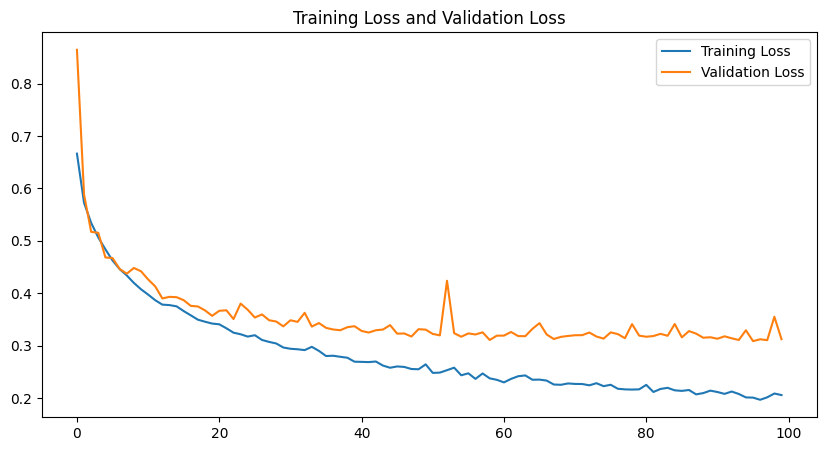

In [21]:
from tqdm import tqdm

train_losses = []
cross_losses = []
bestScore=1
for epoch in range(num_epochs):
    train_loss = train(model, trainDataLoader,dice_loss, optimizer, device, ldl, ldl*4)
    Current_loss = compute_accuracy(testDataLoader,dice_loss, model,device)
    #print(Current_loss)
    #print(CurrentScore)
    train_losses.append(train_loss)
    cross_losses.append(Current_loss)

    clear_output(wait=True)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')
    print(f'Cross Acc: {Current_loss:.4f}')
    #scheduler.step()

    # initialize 3 subplots to plot the loss curve, learning rate curve and accuracy curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(cross_losses, label='Validation Loss')
    plt.title('Training Loss and Validation Loss')
    plt.legend()
    plt.show(block=False)
    
    
    if Current_loss < bestScore:
        bestScore = Current_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

In [22]:
print(1-bestScore)

0.6912783454446232


# Predictions

In [23]:
REAL_img_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 6/masks/image_part_001.png"
img_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 6/images/image_part_001.jpg"  


In [24]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt

model = ImageSegmentation(3)
model.load_state_dict(torch.load('/kaggle/working/best_model.pt', map_location=device))


transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

img = Image.open(img_path)

patch_size = 256
SIZE_X = (img.size[0] // patch_size) * patch_size
SIZE_Y = (img.size[1] // patch_size) * patch_size
large_img = img.crop((0, 0, SIZE_X, SIZE_Y))
large_img = np.array(large_img)

patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)
patches_img = patches_img[:, :, 0, :, :, :]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :, :]
        single_patch_tensor = torch.from_numpy(single_patch_img).float()
        single_patch_tensor /= 255.0
        single_patch_tensor = single_patch_tensor.permute(2, 0, 1)

        single_patch_tensor = transform(single_patch_tensor).unsqueeze(0)  

        with torch.no_grad():
            pred = model(single_patch_tensor)
        pred = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], patch_size, patch_size])

unpatched_prediction = unpatchify(patched_prediction, (SIZE_Y, SIZE_X))


In [25]:
def label_to_rgb(predicted_image):
    
    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152
    
    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246
    
    Road = '#6EC1E4'.lstrip('#') 
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228
    
    Vegetation =  'FEDD3A'.lstrip('#') 
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58
    
    Water = 'E2A929'.lstrip('#') 
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41
    
    Unlabeled = '#9B9B9B'.lstrip('#') 
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155
    
    
    
    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    
    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled
    
    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)

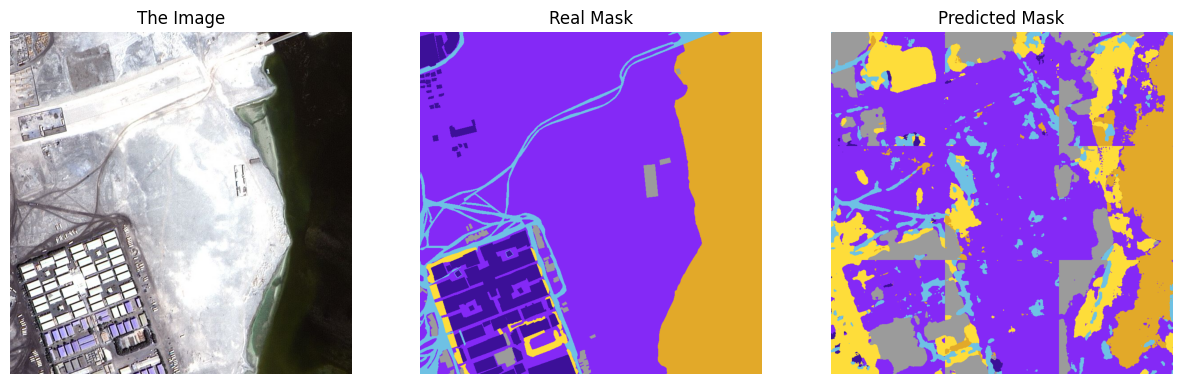

In [26]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Load the images
G_img = Image.open(img_path)
REAL_img = Image.open(REAL_img_path)

# Define patch size and adjust the size of G_img
patch_size = 256
SIZE_X = (G_img.size[0] // patch_size) * patch_size
SIZE_Y = (G_img.size[1] // patch_size) * patch_size
G_img = G_img.crop((0, 0, SIZE_X, SIZE_Y))
G_img = np.array(G_img)


patch_size = 256
SIZE_X = (REAL_img.size[0] // patch_size) * patch_size
SIZE_Y = (REAL_img.size[1] // patch_size) * patch_size
REAL_img = REAL_img.crop((0, 0, SIZE_X, SIZE_Y))
REAL_img = np.array(REAL_img)
REAL_img = np.array(REAL_img)


prediction = label_to_rgb(unpatched_prediction)

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(G_img)
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(REAL_img)
plt.title("Real Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction)
plt.title("Predicted Mask")
plt.axis('off')

plt.show()


# Post Processing

In [27]:
gray = cv2.cvtColor(prediction, cv2.COLOR_RGB2GRAY)

# Detect edges using Sobel filter
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)  # Horizontal edges
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)  # Vertical edges

# Absolute and convert to 8-bit
abs_sobelx = cv2.convertScaleAbs(sobelx)
abs_sobely = cv2.convertScaleAbs(sobely)
edges = cv2.bitwise_or(abs_sobelx, abs_sobely)


_, binary = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Inpaint the original image
post_processed = cv2.inpaint(prediction, binary.astype(np.uint8), 5, cv2.INPAINT_TELEA)

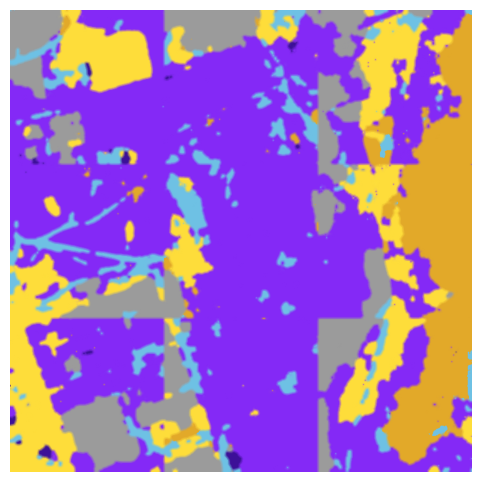

In [28]:
# Plot the result
plt.figure(figsize=(10, 6))
plt.imshow(post_processed)
plt.axis('off')
plt.show()

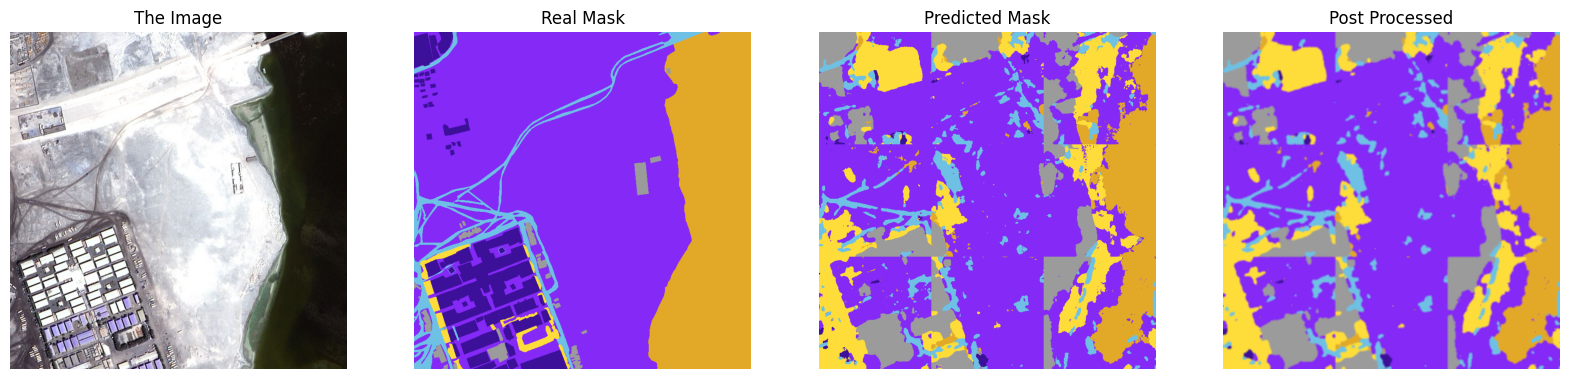

In [29]:
# Plotting the images
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(G_img)
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(REAL_img)
plt.title("Real Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(prediction)
plt.title("Predicted Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(post_processed)
plt.title("Post Processed")
plt.axis('off')

plt.show()

# Post Processing testing

In [30]:
Real = rgb_to_2D_label(REAL_img)
post = rgb_to_2D_label(post_processed)

Real = to_categorical(Real)
post = to_categorical(post)


# Calculate Dice loss for each channel
dice_losses = []
for channel in range(num_channels):
    input_channel = torch.tensor(post[channel]).unsqueeze(0)
    target_channel = torch.tensor(Real[channel]).unsqueeze(0)

    loss_channel = dice_loss(input_channel, target_channel)
    dice_losses.append(loss_channel)

average_dice_loss = np.mean(dice_losses)

# Calculate average Dice score
average_dice_score = 1 - average_dice_loss
print(f'Average Dice Score of post processed maks: {average_dice_score}')

Average Dice Score of post processed maks: 0.19214922189712524


In [31]:
pred = rgb_to_2D_label(prediction)
pred = to_categorical(pred)


# Calculate Dice loss for each channel
dice_losses = []
for channel in range(num_channels):
    input_channel = torch.tensor(pred[channel]).unsqueeze(0)
    target_channel = torch.tensor(Real[channel]).unsqueeze(0)

    loss_channel = dice_loss(input_channel, target_channel)
    dice_losses.append(loss_channel)

average_dice_loss = np.mean(dice_losses)
    
    
# Calculate average Dice score
average_dice_score = 1 - average_dice_loss
print(f'Average Dice Score of predicted mask: {average_dice_score}')

Average Dice Score of predicted mask: 0.2220776081085205


#### The Post-Processing is good as it removes the lines effect without effecting the Dice Coeff very much